In [1]:
import numpy as np

import scipy

from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml

import pandas as pd

from matplotlib import pyplot as plt

# ODE Time Series with RNTK PCA and t-SNE

Run this notebook to generate the figures from the paper _Wearing a MASK: Compressed Representations of Variable-Length Sequences Using Recurrent Neural Tangent Kernels_. Uses code from [https://github.com/thegregyang/NTK4A](https://github.com/thegregyang/NTK4A) to compute the RNTK. Requires `data/Caeuler.mat` to have been generated by the provided Matlab script.

In [2]:
X = scipy.io.loadmat('data/Caeuler.mat')['data']
X.shape

(200, 30)

In [3]:
X /= np.linalg.norm(X, axis=1)[:, None]

In [4]:
X

array([[ 5.15660316e-02, -1.53476559e-02, -4.29709158e-02, ...,
         2.05702814e-01,  3.13247616e-01,  4.06961616e-01],
       [ 4.59993881e-02,  1.30103721e-02,  2.59523012e-02, ...,
        -2.22784486e-01, -8.38393541e-02,  7.74241430e-02],
       [ 1.31984350e-03,  1.59446514e-03,  3.05937769e-03, ...,
        -2.37210126e-01, -4.44590902e-01, -6.02969524e-01],
       ...,
       [ 5.30721522e-06, -2.65360761e-06,  2.65360761e-06, ...,
         3.56887933e-01, -5.72815181e-02, -7.03136057e-01],
       [ 4.29392297e-06, -2.14696149e-06,  2.14696149e-06, ...,
         2.65762186e-01, -1.60833394e-01, -7.63623409e-01],
       [ 5.27226234e-06, -2.63613117e-06,  2.63613117e-06, ...,
         3.49086836e-01, -6.65971488e-02, -7.09057580e-01]])

In [5]:
labels = [0 if i < 100 else 1 for i in range(200)]

In [6]:
X[np.random.rand(*(X.shape)) < 0.2] = 0
A = X.ravel()
mask = A != 0
A = A[mask]
idxs = []
idx = 0
for i in range(X.shape[0]):
    idxs.append(idx)
    idx += np.sum(X[i, :] != 0)
idxs = np.asarray(idxs)

In [7]:
gram_mtx = np.einsum('ik,lm->ilkm', X, X)
gram_mtx.shape
gram_mtx = np.outer(A, A) / 20
#gram_mtx = np.einsum('ij,kl->ikjl', X, X)
#idxs = np.arange(0, len(A), X.shape[1])
gram_mtx.shape, idxs[-1]

((4829, 4829), 4806)

In [8]:
def rnnntk_batch(ingram, Vphi3, Vderphi3,
    varw=1, varu=1, varb=0, varv=1, avgpool=False):
    ''' Compute the RNN-NTK over a batch of sequences of the same length
    Inputs:
        `ingram`: dimension-normalized Gram matrix between all tokens across all input sequences
            of shape [batchsize, batchsize, seqlen, seqlen]
        `Vphi3`: V-transform of nonlin that takes in 3 input arrays (cov, var1, var2)
        `Vderphi3`: V-transform of nonlin derivative that takes in 3 input arrays (cov, var1, var2)
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `varv`: variance of output weights
        `avgpool`: if True, output is the average of all states multiplied by output weights.
            Otherwise, output is just the last state multiplied by output weigths.
    Outputs:
        a dictionary of kernels
        output['ntk'] gives the NTK
        '''
    seqlen = ingram.shape[-1]
    batchsize = ingram.shape[0]
    # hcov[ia, jb] = < h^(i+2,a), h^(j+2,b) >
    hcov = np.zeros(ingram.shape)
    # hhcov[ia, jb] = < \tilde h^(i+1,a), \tilde h^(j+1,b) >
    hhcov = np.zeros(ingram.shape)
    hhcov[..., 0, :] = varu * ingram[..., 0, :] + varb
    hhcov[..., :, 0] = varu * ingram[..., :, 0] + varb
    # fill in zeroed entries
    def reflect(t):
        return np.where(t==0, np.moveaxis(t, [0, 2], [1, 3]), t)
    def hhcov_prep(i=None, b=0):
        if i is None:
            d = np.einsum('aaii->ai', hhcov)
            return np.broadcast_arrays(
                hhcov,
                d.reshape(batchsize, 1, seqlen, 1),
                d.reshape(1, batchsize, 1, seqlen)
            )
        return np.broadcast_arrays(
            hhcov[..., i, b:i+1],
            np.diag(hhcov[..., i, i]).reshape(batchsize, 1, 1),
            np.einsum('aaii->ai', hhcov[..., b:i+1, b:i+1]).reshape(1, batchsize, i+1-b)
        )
    def Vderphi(mat):
        d = np.diag(mat)
        return Vderphi3(mat, d.reshape(-1, 1), d.reshape(1, -1))
    
    for i in range(0, seqlen):
        hcov[..., i, :i+1] = varw * Vphi3(*hhcov_prep(i))
        if i < seqlen - 1:
            hhcov[..., i+1, 1:i+2] = hcov[..., i, :i+1] + varu * ingram[..., i+1, 1:i+2] + varb
    hhcov = reflect(hhcov)
    hcov = reflect(hcov)
    scov = varw**-1 * hcov
    
    if not avgpool:
        dhcov = np.zeros([batchsize, batchsize, seqlen+1])
        dhcov[..., -1] = varv
        for i in range(seqlen-1, -1, -1):
            dhcov[..., i] = varw * Vderphi(hhcov[..., i, i]) * dhcov[..., i+1]
        dhcov /= varw
        dhcov = dhcov[..., :-1]
        
        buf = np.einsum('abii->abi', ingram) + 1
        buf[..., 1:] += np.einsum('abii->abi', scov[..., :-1, :-1])
        ntk = np.einsum('abi,abi->ab', dhcov, buf)
        ntk += scov[..., -1, -1]
        return ntk


    # dscov[ia, jb] = <ds^(i+1,a), ds^(j+1,b)>
    dscov = np.zeros(ingram.shape)
    dscov[..., :, -1] = dscov[..., -1, :] = varv
    for i in range(seqlen-1, 0, -1):
        dscov[..., i-1, :i] = varw * Vderphi3(*hhcov_prep(i, 1)) * dscov[..., i, 1:i+1] + varv
    dscov = reflect(dscov)

    # dhcov[ia, jb] = <d\tilde h^(i+1,a), d\tilde h^(j+1,b)>
    dhcov = Vderphi3(*hhcov_prep()) * dscov
    
    buf = ingram + 1
    buf[..., 1:, 1:] += scov[..., :-1, :-1]
    ntk = np.einsum('abij,abij->ab', dhcov, buf)
    ntk += np.sum(scov, axis=(-1, -2))
    return dict(ntk=ntk / seqlen**2, dscov=dscov, scov=scov, hcov=hcov, hhcov=hhcov)

def rnnntk(ingram, inputidxs, Vphi3, Vderphi3,
    varw=1, varu=1, varb=0, varv=1,
    maxlength=None):
    '''Compute the RNN-NTK over a batch of sequences of the different lengths
    Inputs:
        `ingram`: dimension-normalized Gram matrix between all tokens across all input sequences
        `inputidxs`: indices of `ingram` that indicate starts of input sequences
        `Vphi3`: V transform of the nonlinearity of the RNN (e.g. arcsin for step function, etc)
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `varv`: variance of output weights
        `maxlength`: max length of all sequences. Default: None.
            In this case, it is calculated from `inputidxs`
    Outputs:
        a dictionary of kernels
        output['ntk'] gives the NTK
    '''
    if maxlength is None:
        maxlength = 0
        for i in range(len(inputidxs)-1):
            maxlength = max(maxlength, inputidxs[i+1]-inputidxs[i])

    # hcov[ia, jb] = < h^(i+2,a), h^(j+2,b) >
    hcov = np.zeros(ingram.shape)
    # hhcov[ia, jb] = < h^(i+1,a), h^(j+1,b) >
    hhcov = np.zeros(ingram.shape)
    for _ in range(maxlength):
        hhcov[1:, 1:] = hcov[:-1, :-1]
        hhcov[inputidxs, :] = hhcov[:, inputidxs] = 0
        hhcov += varu * ingram + varb
        hcov = varw * Vphi3(hhcov)
    # scov[ia, jb] = < s^(i+1,a), s^(j+1,b) >
    scov = varw**-1 * hcov
    hhcov[1:, 1:] = hcov[:-1, :-1]
    hhcov[inputidxs, :] = hhcov[:, inputidxs] = 0
    hhcov += varu * ingram + varb
    
    # dscov[ia, jb] = <ds^(i+1,a), ds^(j+1,b)>
    dscov = np.zeros(ingram.shape)
    # endidxs = indices of the ends of sentences
    endidxs = list(inputidxs)[1:]
    endidxs = np.array(endidxs + [0]) - 1
    for _ in range(maxlength):
        dscov[endidxs, :] = dscov[:, endidxs] = 0
        idxs = np.meshgrid(endidxs, endidxs)
        # setting <ds^(-1,a), ds^(-1,b)> = varv
        dscov[idxs[0].reshape(-1), idxs[1].reshape(-1)] = varv
        # <ds^(i+1,a), ds^(j+1,b)> = varw * Vderphi3(h^(i+1,a), h^(j+1,b)) * <ds^(i+2,a), ds^(j+2,b)>
        dscov[:-1, :-1] = varw * Vderphi3(hhcov[1:, 1:]) * dscov[1:, 1:]
    dscov[endidxs, :] = dscov[:, endidxs] = 0
    idxs = np.meshgrid(endidxs, endidxs)
    dscov[idxs[0].reshape(-1), idxs[1].reshape(-1)] = varv
    
    # dhcov[ia, jb] = <d\tilde h^(i+1,a), d\tilde h^(j+1,b)>
    dhcov = Vderphi3(hhcov) * dscov
    
    # shifted_scov[ia, jb] = < s^(i,a), s^(j,b) >
    shifted_scov = np.zeros(ingram.shape)
    shifted_scov[1:, 1:] = scov[:-1, :-1]
    shifted_scov[inputidxs, :] = shifted_scov[:, inputidxs] = 0
    prd = dhcov * (ingram + shifted_scov + 1)
    
    ntk = np.zeros([len(inputidxs), len(inputidxs)])
    # can't find a vectorized implementation for the following
    for i in range(len(inputidxs)):
        for j in range(len(inputidxs)):
            ei = endidxs[i] + 1 if endidxs[i] != -1 else prd.shape[0]
            ej = endidxs[j] + 1 if endidxs[j] != -1 else prd.shape[0]
            ntk[i, j] = np.sum(
                prd[inputidxs[i]:ei,
                    inputidxs[j]:ej]
            ) + scov[endidxs[i], endidxs[j]]
    return dict(ntk=ntk, dscov=dscov, scov=scov, hcov=hcov, hhcov=hhcov)

def J2(c, eps=1e-10):
    c[c > 1-eps] = 1-eps
    c[c < -1+eps] = -1+eps
    return ( np.pi - np.arccos(c) ) / np.pi

def VderReLU(cov, eps=1e-5):
    ll = list(range(cov.shape[-1]))
    d = np.sqrt(cov[..., ll, ll])
    c = d[..., None]**(-1) * cov * d[..., None, :]**(-1)
    return np.nan_to_num( J2(c, eps=eps) )

In [9]:
import cProfile

In [10]:
varw = 4
varu = 0.1
varb = 1e-10
varv = 1
from utils import clone_grads, paramdot, VErf3, VDerErf3, VReLU
#cProfile.run('rnnntk_batch(gram_mtx, VErf3, VDerErf3, varw, varu, varb, varv)')
K = rnnntk(gram_mtx, idxs, VReLU, VderReLU, varw, varu, varb, varv, maxlength=20)['ntk']

In [11]:
k = np.diag(K)
K /= np.sqrt(np.outer(k, k))
D = 1 - K

In [12]:
d, u = np.linalg.eig(K)

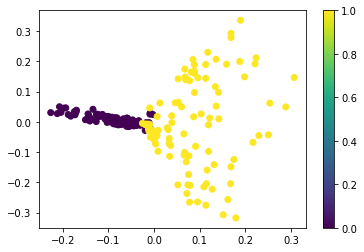

In [13]:
kpca = KernelPCA(kernel='precomputed')
X_ = kpca.fit_transform(K + np.eye(len(labels)) * 0.1)
x_kpca, y_kpca = X_[:, :2].T

plt.scatter(x_kpca, y_kpca, c=[int(l) for l in labels])
plt.colorbar()

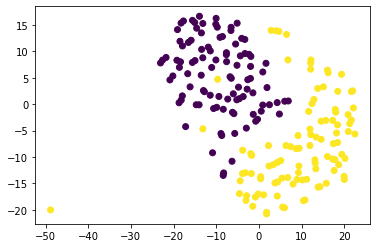

In [14]:
tsne = TSNE(2, metric='precomputed')
X_ = tsne.fit_transform(D)
x_ktsne, y_ktsne = X_[:, :2].T

plt.scatter(x_ktsne, y_ktsne, c=[int(l) for l in labels])

In [15]:
X_nokernel = X.copy()
for i in range(X_nokernel.shape[0]):
    x = X_nokernel[i, :]
    X_nokernel[i, :] = np.concatenate((x[x != 0], np.zeros(np.sum(x == 0))))
X_nokernel.shape

(200, 30)

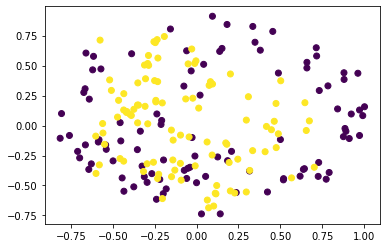

In [16]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_ = pca.fit_transform(X_nokernel)
x_pca, y_pca = X_[:, :2].T

plt.scatter(x_pca, y_pca, c=[int(l) for l in labels])

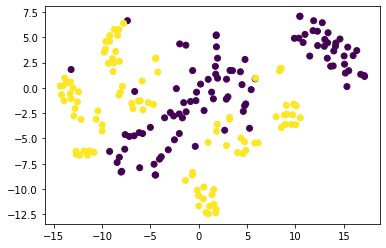

In [17]:
tsne = TSNE(2)
X_ = tsne.fit_transform(X_nokernel)
x_tsne, y_tsne = X_[:, :2].T

plt.scatter(x_tsne, y_tsne, c=[int(l) for l in labels])

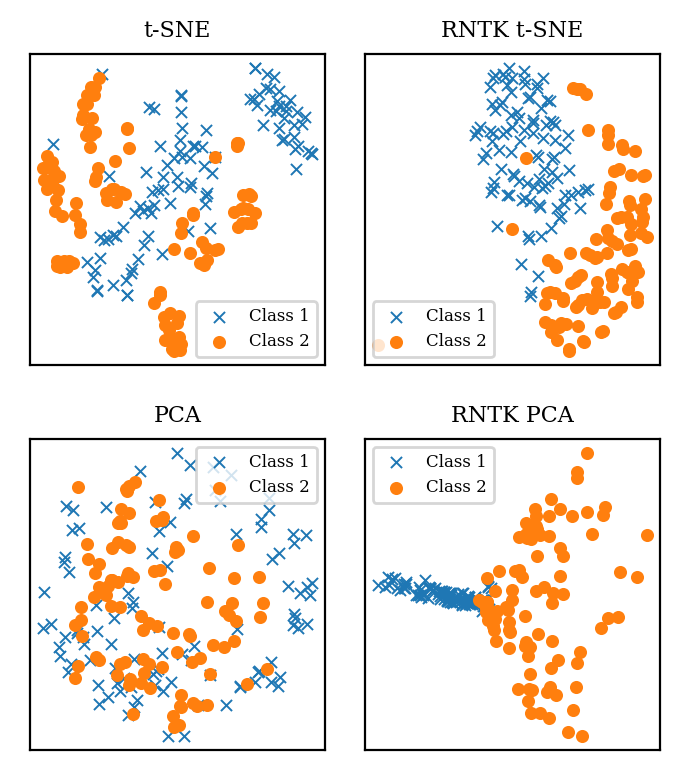

In [18]:
plt.figure(dpi=200, figsize=(3.5, 4))

plt.subplot(2, 2, 1)
for i, j, m, l in [(0, 100, 'x', 'Class 1'), (100, 200, 'o', 'Class 2')]:
    plt.scatter(x_tsne[i:j], y_tsne[i:j], marker=m, s=16, linewidths=0.7, label=l)
plt.title('t-SNE', font={'family': 'DejaVu Serif', 'size': 8})
plt.legend(prop={'size': 6, 'family': 'DejaVu Serif'})
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 2, 2)
for i, j, m, l in [(0, 100, 'x', 'Class 1'), (100, 200, 'o', 'Class 2')]:
    plt.scatter(x_ktsne[i:j], y_ktsne[i:j], marker=m, s=16, linewidths=0.7, label=l)
plt.title('RNTK t-SNE', font={'family': 'DejaVu Serif', 'size': 8})
plt.legend(prop={'size': 6, 'family': 'DejaVu Serif'})
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 2, 3)
for i, j, m, l in [(0, 100, 'x', 'Class 1'), (100, 200, 'o', 'Class 2')]:
    plt.scatter(x_pca[i:j], y_pca[i:j], marker=m, s=16, linewidths=0.7, label=l)
plt.title('PCA', font={'family': 'DejaVu Serif', 'size': 8})
plt.legend(prop={'size': 6, 'family': 'DejaVu Serif'})
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 2, 4)
for i, j, m, l in [(0, 100, 'x', 'Class 1'), (100, 200, 'o', 'Class 2')]:
    plt.scatter(x_kpca[i:j], y_kpca[i:j], marker=m, s=16, linewidths=0.7, label=l)
plt.title('RNTK PCA', font={'family': 'DejaVu Serif', 'size': 8})
plt.legend(prop={'size': 6, 'family': 'DejaVu Serif'})
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig('tsne_pca_comp.pdf')
plt.show()